## Importing Modules


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import load_files
from glob import glob

In [2]:
import keras 
from keras.utils import np_utils

Using TensorFlow backend.


## Loading Dataset

In [3]:
def load_dataset(path):
    data = load_files(path, shuffle=True)
    img_files = np.array(data['filenames'])
    img_targets = np_utils.to_categorical(np.array(data['target']), 3)
    return img_files, img_targets

In [4]:
train_files, train_labels = load_dataset('data/train/train')
valid_files, valid_labels = load_dataset('data/valid/valid')

In [5]:
def load_dataset_no_shuffle(path):
    data = load_files(path, shuffle=False)
    img_files = np.array(data['filenames'])
    img_targets = np_utils.to_categorical(np.array(data['target']), 3)
    return img_files, img_targets

In [6]:
test_files , test_labels = load_dataset_no_shuffle('data/test')

In [7]:
from keras.preprocessing import image
from tqdm import tqdm

def path_to_tensor(path):
    
    img = image.load_img(path, target_size = (224,224))
    x= image.img_to_array(img)
    return np.expand_dims(x, axis=0)

def paths_to_tensor(paths):
    list_of_tensors = [path_to_tensor(path) for path in tqdm(paths)]
    return np.vstack(list_of_tensors)

## Loading images into Tensors

In [8]:
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|█████████████████████████████████████████████████████████████████████████████| 600/600 [09:53<00:00,  1.01it/s]


In [9]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

# Transfer Learning using Inception

In [24]:
from keras.applications.inception_v3 import InceptionV3

model_inception = InceptionV3(weights = 'imagenet', include_top = False)

In [25]:
train_features_inception = model_inception.predict(train_tensors, verbose=1)
valid_features_inception = model_inception.predict(valid_tensors, verbose=1)
test_features_inception = model_inception.predict(test_tensors, verbose=1)

600/600 [==============================] - 5s 8ms/step


## Network Model

In [26]:
model = Sequential()

model.add(GlobalAveragePooling2D(input_shape = train_features_inception.shape[1:]))
model.add(Dropout(0.2))
model.add(Dense(1024, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation ='softmax'))


model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_6 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)              

## Declaring Optimizers

In [27]:
opt = keras.optimizers.Adam(lr=0.0001, decay=1e-6)
model.compile(optimizer= opt, metrics = ['accuracy'], loss='categorical_crossentropy')

## Trainig Model

In [31]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(save_best_only = True, verbose =1, 
                             filepath = 'saved_models/weights.best.from_inception.hdf5')

model.fit(train_features_inception, 
          train_labels, 
          epochs=35, 
          batch_size= 64, 
          validation_data=(valid_features_inception, valid_labels), callbacks=[checkpoint], verbose=1
         )

Train on 2000 samples, validate on 150 samples
Epoch 1/35
2000/2000 [==============================] - 2s 780us/step - loss: 0.6090 - accuracy: 0.7345 - val_loss: 0.7844 - val_accuracy: 0.6733

Epoch 00001: val_loss improved from inf to 0.78437, saving model to saved_models/weights.best.from_inception.hdf5
Epoch 2/35
2000/2000 [==============================] - 2s 844us/step - loss: 0.6224 - accuracy: 0.7345 - val_loss: 0.7679 - val_accuracy: 0.6733

Epoch 00002: val_loss improved from 0.78437 to 0.76786, saving model to saved_models/weights.best.from_inception.hdf5
Epoch 3/35
2000/2000 [==============================] - 1s 381us/step - loss: 0.5868 - accuracy: 0.7560 - val_loss: 0.7731 - val_accuracy: 0.6600

Epoch 00003: val_loss did not improve from 0.76786
Epoch 4/35
2000/2000 [==============================] - 1s 424us/step - loss: 0.5695 - accuracy: 0.7685 - val_loss: 0.8017 - val_accuracy: 0.6667

Epoch 00004: val_loss did not improve from 0.76786
Epoch 5/35
2000/2000 [=========

## Loading Saved Weights

In [32]:
model.load_weights('saved_models/weights.best.from_inception.hdf5')


## Predicting Accuracy

In [33]:
test_predictions = np.argmax(model.predict(test_features_inception), axis=1)
accuracy = 100 * np.sum(np.array(test_predictions) == np.argmax(test_labels, axis=1))/len(test_predictions)
print ('Accuracy of Inception model on test set = %.4f%%' % accuracy)

Accuracy of Inception model on test set = 70.5000%


In [34]:
print(np.argmax(test_labels[25]))
print(test_predictions[25])

0
0


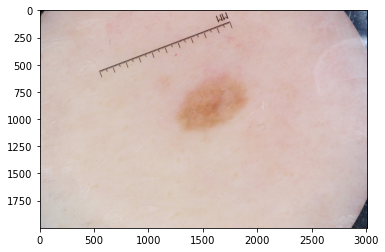

In [36]:
import cv2
img = cv2.imread(test_files[35])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

In [37]:
test_predictions = model.predict(test_features_inception)
test_predictions_task1 = test_predictions[:,0]
test_predictions_task2 = test_predictions[:,2]

In [38]:
submission_inception = pd.DataFrame({'Id':test_files, 'task_1':test_predictions_task1,'task_2':test_predictions_task2})
pd.DataFrame.to_csv(submission_inception, 'submission.csv', index=False)

## Plotting ROC curve and Confusion Matrix

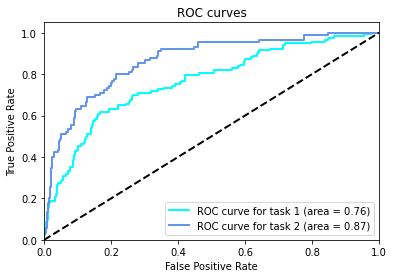

Category 1 Score: 0.764
Category 2 Score: 0.865
Category 3 Score: 0.814


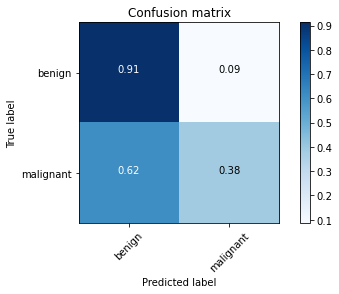

In [47]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys

from sklearn.metrics import roc_curve, auc, confusion_matrix

def plot_roc_auc(y_true, y_pred):
    """
    This function plots the ROC curves and provides the scores.
    """

    # initialize dictionaries and array
    fpr = dict()
    tpr = dict()
    roc_auc = np.zeros(3)
    
    # prepare for figure
    plt.figure()
    colors = ['aqua', 'cornflowerblue']

    # for both classification tasks (categories 1 and 2)
    for i in range(2):
        # obtain ROC curve
        fpr[i], tpr[i], _ = roc_curve(y_true[:,i], y_pred[:,i])
        # obtain ROC AUC
        roc_auc[i] = auc(fpr[i], tpr[i])
        # plot ROC curve
        plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
                 label='ROC curve for task {d} (area = {f:.2f})'.format(d=i+1, f=roc_auc[i]))
    # get score for category 3
    roc_auc[2] = np.average(roc_auc[:2])
    
    # format figure
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curves')
    plt.legend(loc="lower right")
    plt.show()
    
    # print scores
    for i in range(3):
        print('Category {d} Score: {f:.3f}'. format(d=i+1, f=roc_auc[i]))

def plot_confusion_matrix(y_true, y_pred, thresh, classes):
    """
    This function plots the (normalized) confusion matrix.
    """

    # obtain class predictions from probabilities
    y_pred = (y_pred>=thresh)*1
    # obtain (unnormalized) confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # normalize confusion matrix
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

if __name__ == "__main__":

    preds_path = sys.argv[1]
    
    thresh = 0.5

    # get ground truth labels for test dataset
    truth = pd.read_csv('ground_truth.csv')
    y_true = truth[["task_1", "task_2"]].values

    # get model predictions for test dataset
    y_pred = pd.read_csv('submission.csv')
    y_pred = y_pred[["task_1", "task_2"]].values

    # plot ROC curves and print scores
    plot_roc_auc(y_true, y_pred)
    # plot confusion matrix
    classes = ['benign', 'malignant']
    plot_confusion_matrix(y_true[:,0], y_pred[:,0], thresh, classes)

# Transfer Learning using InceptionResnet

In [10]:
from keras.applications.inception_resnet_v2 import InceptionResNetV22

model_inception_resnet = InceptionResNetV2(weights = 'imagenet', include_top = False)

In [12]:
train_features_inception = model_inception_resnet.predict(train_tensors, verbose=1)
valid_features_inception = model_inception_resnet.predict(valid_tensors, verbose=1)
test_features_inception = model_inception_resnet.predict(test_tensors, verbose=1)

600/600 [==============================] - 8s 13ms/step


## Network Model

In [13]:
model_inception_resnet = Sequential()

model_inception_resnet.add(GlobalAveragePooling2D(input_shape = train_features_inception.shape[1:]))
model_inception_resnet.add(Dropout(0.2))
model_inception_resnet.add(Dense(1024, activation = 'relu'))
model_inception_resnet.add(Dropout(0.2))
model_inception_resnet.add(Dense(512, activation = 'relu'))
model_inception_resnet.add(Dropout(0.2))
model_inception_resnet.add(Dense(128, activation = 'relu'))
model_inception_resnet.add(Dropout(0.2))
model_inception_resnet.add(Dense(3, activation ='softmax'))


model_inception_resnet.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 1536)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1536)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1573888   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)              

## Optimizers

In [ ]:
opt = keras.optimizers.Adam(lr=0.0001, decay=1e-6)
model_inception_resnet.compile(optimizer= opt, metrics = ['accuracy'], loss='categorical_crossentropy')

## Training Model

In [15]:
from keras.callbacks import ModelCheckpoint

checkpoint_inception = ModelCheckpoint(
    save_best_only = True, 
    verbose = 1, 
    filepath = 'saved_models/weights.best.from_inception_resnet_v2.hdf5')

model_inception_resnet.fit(train_features_inception, 
          train_labels, 
          epochs=35, 
          batch_size= 64, 
          validation_data=(valid_features_inception, valid_labels), callbacks=[checkpoint_inception], verbose=1
         )

Train on 2000 samples, validate on 150 samples
Epoch 1/35
2000/2000 [==============================] - 2s 1ms/step - loss: 0.8759 - accuracy: 0.6600 - val_loss: 1.0328 - val_accuracy: 0.5200

Epoch 00001: val_loss improved from inf to 1.03276, saving model to saved_models/weights.best.from_inception_resnet_v2.hdf5
Epoch 2/35
2000/2000 [==============================] - 1s 740us/step - loss: 0.7685 - accuracy: 0.6915 - val_loss: 0.9049 - val_accuracy: 0.5600

Epoch 00002: val_loss improved from 1.03276 to 0.90485, saving model to saved_models/weights.best.from_inception_resnet_v2.hdf5
Epoch 3/35
2000/2000 [==============================] - 1s 688us/step - loss: 0.7364 - accuracy: 0.6855 - val_loss: 0.8014 - val_accuracy: 0.6400

Epoch 00003: val_loss improved from 0.90485 to 0.80139, saving model to saved_models/weights.best.from_inception_resnet_v2.hdf5
Epoch 4/35
2000/2000 [==============================] - 1s 734us/step - loss: 0.7195 - accuracy: 0.6975 - val_loss: 0.7839 - val_accur

## Loading Saved Weights

In [16]:
model_inception_resnet.load_weights('saved_models/weights.best.from_inception_resnet_v2.hdf5')

## Predicting Accuracy

In [17]:
test_predictions = np.argmax(model_inception_resnet.predict(test_features_inception), axis=1)
accuracy = 100 * np.sum(np.array(test_predictions) == np.argmax(test_labels, axis=1))/len(test_predictions)
print ('Accuracy of Inception model on test set = %.4f%%' % accuracy)

Accuracy of Inception model on test set = 67.0000%


In [48]:
submission_inception_resnet = pd.DataFrame({'Id':test_files, 'task_1':test_predictions_task1,'task_2':test_predictions_task2})
pd.DataFrame.to_csv(submission_inception_resnet, 'submission.csv', index=False)

## Plotting ROC curve and Confusion matrix

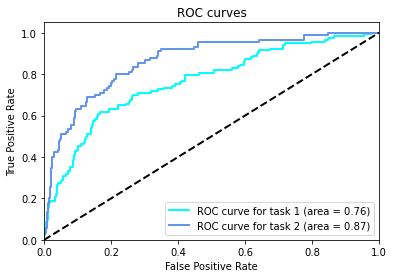

Category 1 Score: 0.764
Category 2 Score: 0.865
Category 3 Score: 0.814


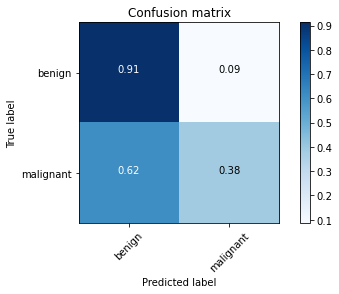

In [53]:
preds_path = sys.argv[1]
    
thresh = 0.5

# get ground truth labels for test dataset
truth = pd.read_csv('ground_truth.csv')
y_true = truth[["task_1", "task_2"]].values

# get model predictions for test dataset
y_pred = pd.read_csv('submission.csv')
y_pred = y_pred[["task_1", "task_2"]].values

# plot ROC curves and print scores
plot_roc_auc(y_true, y_pred)
# plot confusion matrix
classes = ['benign', 'malignant']
plot_confusion_matrix(y_true[:,0], y_pred[:,0], thresh, classes)